# Walk-through
Training - Compress - Visualization

## Clone Repo
I directly mounted a Google Drive. Clone the repo as needed

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR


In [2]:
!pip install pytorch_msssim

## Training

Using image 21 for example, we train a wide but shallow INR (layer size of 150 with 2 layers). Refer to the COIN paper/repo for more information

Image 22 -- layer size of 300 with 2 layers

Image 25 is a surprise image and is not part of the Kodak dataset -- Layer size of 200 with 4 layers

Image 3, 4 -- No bias vs Bias

Image 5 -- Varying num layer and layer size with no bias

In [8]:
!python train.py --num_iters 5000 --layer_size 200 --num_layers 1 --image_id 5 --w0 30.0

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
Fitting SIREN to Kodak Image5...
Model size: 4.8kB
Full precision bpp: 0.10
100%|██████████████████| 5000/5000 [00:39<00:00, 126.64it/s, best_psnr=16.6, loss=0.0221, psnr=16.6]
Best training psnr: 16.56


## Apply post-training sparsification/quantization algorithms
Make sure that the image id, layer size and number of layers are consistent as the training input

### Quantization
Only supports half precision quantization right now.


In [ ]:
!python compress.py --image_id 17 --compression_type Quantization --layer_size 30 --num_layers 10 --w0 1.0 --quant_level half

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

### Magnitude Pruning
prune_ratio of 0.5 is 50% pruning.

In [ ]:
!python compress.py --image_id 17 --compression_type Mag_Pruning --layer_size 30 --num_layers 10 --w0 1.0  --prune_ratio 0.5 --refine_iter 5000

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

### SuRP

In [ ]:
!python compress.py --image_id 1 --compression_type SuRP --layer_size 50 --num_layers 15 --surp_iter 100000 --image_iter 1000

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/modules/model_compression.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless

## Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image
image_id = 25
base_path = f'results/image_{image_id}'
base_SuRP_path = base_path + '/SuRP'

### Image Display
Original image - Full INR Reconstruction - Quantized (Half Precision) Reconstruction

Pruned Reconstruction - SuRP Reconstruction (Iter 50000) - SuRP Reconstruction (Iter 100000)

In [ ]:
original = imageio.imread(f'kodak-dataset/kodim{image_id}.png')
full = imageio.imread(base_path + f'/Best_Model_Reconstruction_{image_id}.png')
quant = imageio.imread(base_path + f'/Quantization_reconstruction_{image_id}.png')
pruned = imageio.imread(base_path + f'/Mag_Pruning_reconstruction_{image_id}.png')
SuRP_50000 = imageio.imread(base_SuRP_path + f'/SuRP_reconstruction_{image_id}_150000.png')
SuRP_99000 = imageio.imread(base_SuRP_path + f'/SuRP_reconstruction_{image_id}_297000.png')

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

axes[0, 0].imshow(original)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(full)
axes[0, 1].set_title('Best Model Reconstruction')
axes[0, 1].axis('off')

axes[1, 0].imshow(quant)
axes[1, 0].set_title('Quantization Reconstruction')
axes[1, 0].axis('off')

axes[1, 1].imshow(pruned)
axes[1, 1].set_title('Magnitude Pruning Reconstruction')
axes[1, 1].axis('off')

axes[2, 0].imshow(SuRP_50000)
axes[2, 0].set_title('SuRP Reconstruction (150,000)')
axes[2, 0].axis('off')

axes[2, 1].imshow(SuRP_99000)
axes[2, 1].set_title('SuRP Reconstruction (297,000)')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Empirical Weight Distribution and Iter vs. Sparsity/PSNR/MS-SSIM Plot

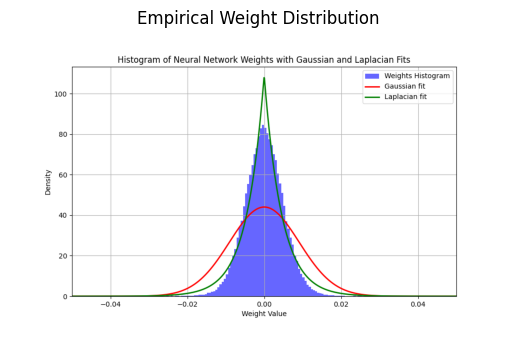

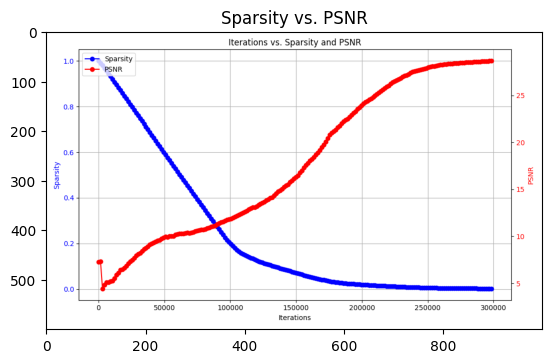

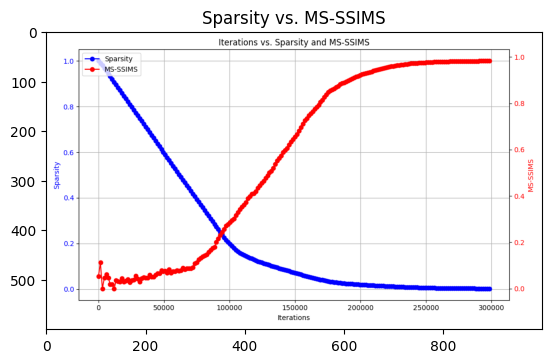

In [ ]:
weight_dist = imageio.imread(base_SuRP_path + '/weight_plot_histogram.png')
psnr_plot = imageio.imread(base_SuRP_path + '/sparsity_psnr_plot.png')
ssim_plot = imageio.imread(base_SuRP_path + '/sparsity_ssims_plot.png')


plt.imshow(weight_dist)
plt.title('Empirical Weight Distribution')
plt.axis('off')
plt.show()

plt.imshow(psnr_plot)
plt.title('Sparsity vs. PSNR')
plt.show()

plt.imshow(ssim_plot)
plt.title('Sparsity vs. MS-SSIMS')
plt.show()

### SuRP Animation

In [ ]:
# Convert to a looped gif
!sudo apt-get install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

In [ ]:
!convert '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_17/SuRP/result_animation.gif' -loop 0 '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_17/SuRP/result_animation_looped.gif'
!convert '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_17/SuRP/residues/result_animation.gif' -loop 0 '/content/drive/Othercomputers/My MacBook Pro/Projects/SR-INR/results/image_17/SuRP/residues/result_animation_looped.gif'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
loaded = np.load('recon_data.npy')

In [ ]:
loaded

array([ 8,  9,  8, ..., 11,  7, 12])

MovieWriter imagemagick unavailable; using Pillow instead.


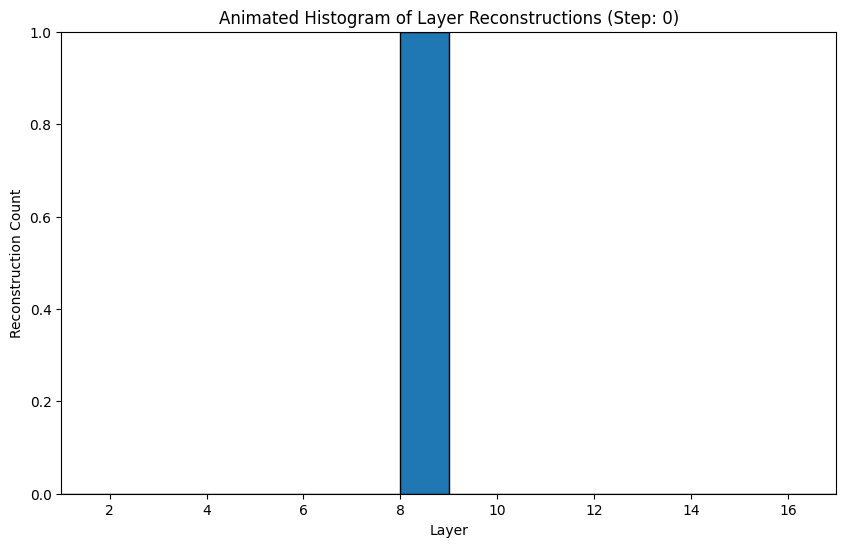

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming `loaded` is your array
# Replace with the actual loaded data if different
data = loaded[:20000]

# Initialize the figure and axis for the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Set up the initial histogram
hist, bins, _ = ax.hist([], bins=np.arange(1, np.max(data) + 2), edgecolor='black')
ax.set_xlim(1, np.max(data) + 1)
ax.set_ylim(0, 1)  # Initially set low, auto-scaled during the animation
ax.set_title('Animated Histogram of Layer Reconstructions')
ax.set_xlabel('Layer')
ax.set_ylabel('Reconstruction Count')

# Function to update the histogram for each frame
def update(frame):
    # Update the counts for the histogram
    current_data = data[:frame + 1]
    ax.cla()  # Clear the current axis
    ax.hist(current_data, bins=np.arange(1, np.max(data) + 2), edgecolor='black')
    ax.set_xlim(1, np.max(data) + 1)
    ax.set_ylim(0, np.max(np.bincount(current_data)))
    ax.set_title(f'Animated Histogram of Layer Reconstructions (Step: {frame})')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Reconstruction Count')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(data), repeat=False, interval=50)

# Save the animation as a GIF or display it
# To display:
#plt.show()

# If you want to save the animation, use:
ani.save('animated_histogram.gif', writer='imagemagick', fps=30)
